# Shifted Beta Geometric model with individual customer data

In this notebook we replicate the main results and figures from 

Fader, P. S., & Hardie, B. G. (2007). How to project customer retention. Journal of Interactive Marketing, 21(1), 76-90. https://journals.sagepub.com/doi/pdf/10.1002/dir.20074

The authors describe the Shifted Beta Geometric (sBG) model for customer behavior in a discrete contractual setting. It assumes that:
  * At the end of each period, a customer has a probability `theta` of renewing the contract
    and `1-theta` of cancelling
  * The probability `theta` does not change over time for a given customer
  * The probability `theta` varies across customers according to a Beta prior distribution
    with hyperparameters `alpha` and `beta`.

In [1]:
import pytensor

#set flag to hotfix open c++ errors
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from pymc_marketing import clv
import pymc as pm
from pymc_extras.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


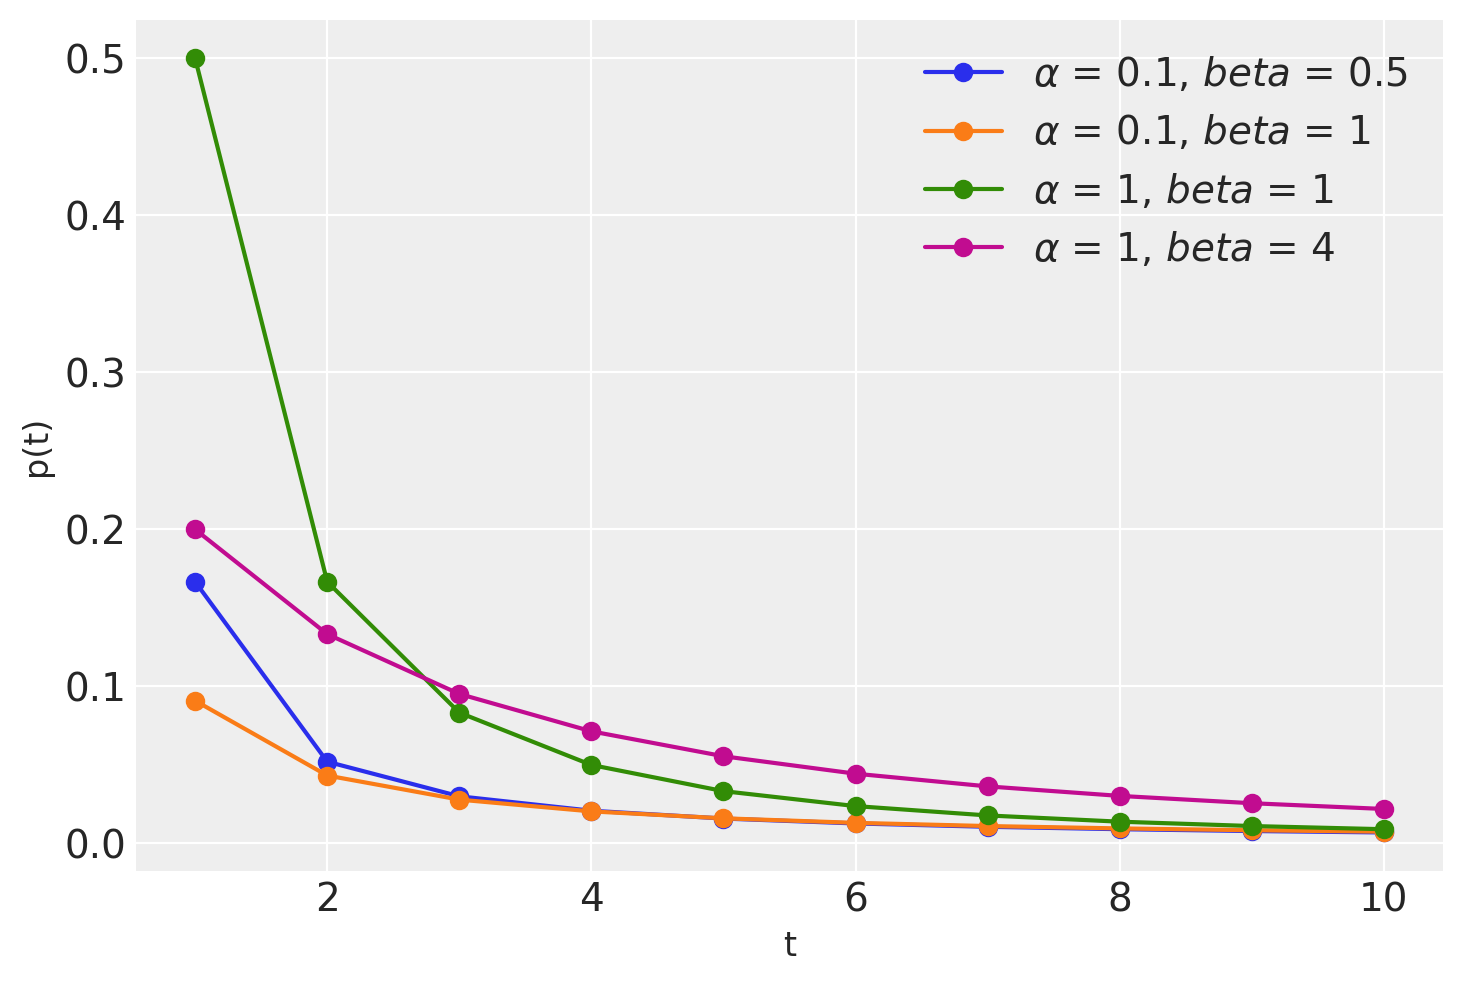

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.special import beta
import arviz as az

plt.style.use('arviz-darkgrid')
t = np.arange(1, 11)
alpha_vals = [.1, .1, 1, 1]
beta_vals = [.5, 1, 1, 4]
for alpha, _beta in zip(alpha_vals, beta_vals):
    pmf = beta(alpha + 1, _beta + t - 1) / beta(alpha, _beta)
    plt.plot(t, pmf, '-o', label=r'$\alpha$ = {}, $beta$ = {}'.format(alpha, _beta))
plt.xlabel('t', fontsize=12)
plt.ylabel('p(t)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [4]:
seed = sum(map(ord, "Individual sBG Model"))
rng = np.random.default_rng(seed)

## Recreating the dataset

The dataset contains the percentage of customers still enrolled in the service after each time period. There are two distinct groups of users: regular and high-end, believed to have different attrition rates. Each group had 1000 customers at the start.

As in the original paper, we will fit the data from the first 7 time periods only, and use the following periods for validation.

In [5]:
df = pd.DataFrame(
    {
        "regular": [
            100.0,
            63.1,
            46.8,
            38.2,
            32.6,
            28.9,
            26.2,
            24.1,
            22.3,
            20.7,
            19.4,
            18.3,
            17.3,
        ],
        "highend": [
            100.0,
            86.9,
            74.3,
            65.3,
            59.3,
            55.1,
            51.7,
            49.1,
            46.8,
            44.5,
            42.7,
            40.9,
            39.4,
        ],
    }
)
df

,regular,highend
0,100.0,100.0
1,63.1,86.9
2,46.8,74.3
3,38.2,65.3
4,32.6,59.3
5,28.9,55.1
6,26.2,51.7
7,24.1,49.1
8,22.3,46.8
9,20.7,44.5


The implemented pymc-marketing model fits each individual `theta`, 
in contrast to the paper approach where the inidividual parameters are marginalized out.

For our analysis we wil have to create a synthetic dataset with individual data, following the aggregate group trends.

In [6]:
def individual_data_from_percentage_alive(percentage_alive, initial_customers):
    n_alive = np.asarray(percentage_alive / 100 * initial_customers, dtype=int)

    died_at = np.zeros((initial_customers,), dtype=int)
    counter = 0
    for t, diff in enumerate((n_alive[:-1] - n_alive[1:]), start=1):
        died_at[counter : counter + diff] = t
        counter += diff

    censoring_t = t + 1
    died_at[counter:] = censoring_t

    return died_at

In [7]:
T = 8  # In the paper only the first 7 years are included in the model

truncated_df = df[:T]
initial_customers = 1000  # Seems to be what F&H use, according to Appendix B
churn_highend = individual_data_from_percentage_alive(
    truncated_df["highend"], initial_customers
)
churn_regular = individual_data_from_percentage_alive(
    truncated_df["regular"], initial_customers
)
churn_regular[::10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 6, 6, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

Customers which haven't churned have `t_churn == T == 8`. 
The model will handle these differently, as their lifetimes are [censored](https://en.wikipedia.org/wiki/Censoring_(statistics)).

In [8]:
dataset_regular = pd.DataFrame(
    {
        "customer_id": np.arange(initial_customers),
        "t_churn": churn_regular,
        "T": T,
        "cohort": "regular",
    }
)

dataset_highend = pd.DataFrame(
    {
        "customer_id": np.arange(initial_customers)+1000,
        "t_churn": churn_highend,
        "T": T,
        "cohort": "highend",
    }
)

dataset = pd.concat([dataset_regular, dataset_highend])

In [9]:
dataset.describe()

,customer_id,t_churn,T
count,2000.000000,2000.000000,2000.0
mean,999.500000,4.508000,8.0
std,577.494589,2.981842,0.0
min,0.000000,1.000000,8.0
25%,499.750000,1.750000,8.0
50%,999.500000,4.000000,8.0
75%,1499.250000,8.000000,8.0
max,1999.000000,8.000000,8.0


## Fitting the sBG models for high end and regular users

## `ShiftedBetaGeoModel` Population

In [10]:
cohort_idx = pd.Categorical(dataset["cohort"], categories=["regular","highend"]).codes  # shape (N,)


In [11]:
coords = {
    "customer_id": dataset["customer_id"],
    "cohort": ["regular","highend"],
}
with pm.Model(coords=coords) as model:
    
    # alpha = pm.HalfFlat("alpha",dims="cohort")
    # beta = pm.HalfFlat("beta",dims="cohort")

    phi = pm.Uniform("phi", lower=0, upper=1,dims="cohort")
    kappa = pm.Pareto("kappa", alpha=1,m=1,dims="cohort")

    alpha = pm.Deterministic("alpha", phi * kappa,dims="cohort")
    beta = pm.Deterministic("beta", (1 - phi) * kappa,dims="cohort")
    theta = pm.Beta("dropout",alpha=alpha,beta=beta)
    

    sbg = clv.distributions.ShiftedBetaGeometric.dist(
        alpha[cohort_idx],
        beta[cohort_idx],
    )

    pm.Censored(
        "churn_censored",
        sbg,
        lower=None,
        upper=dataset["T"],
        observed=dataset["t_churn"],
        dims="customer_id",
    )

    idata = pm.sample()#nuts_sampler="nutpie")
    #idata = pm.find_MAP()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, kappa, dropout]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'dropout'}>,
        <Axes: title={'center': 'dropout'}>]], dtype=object)

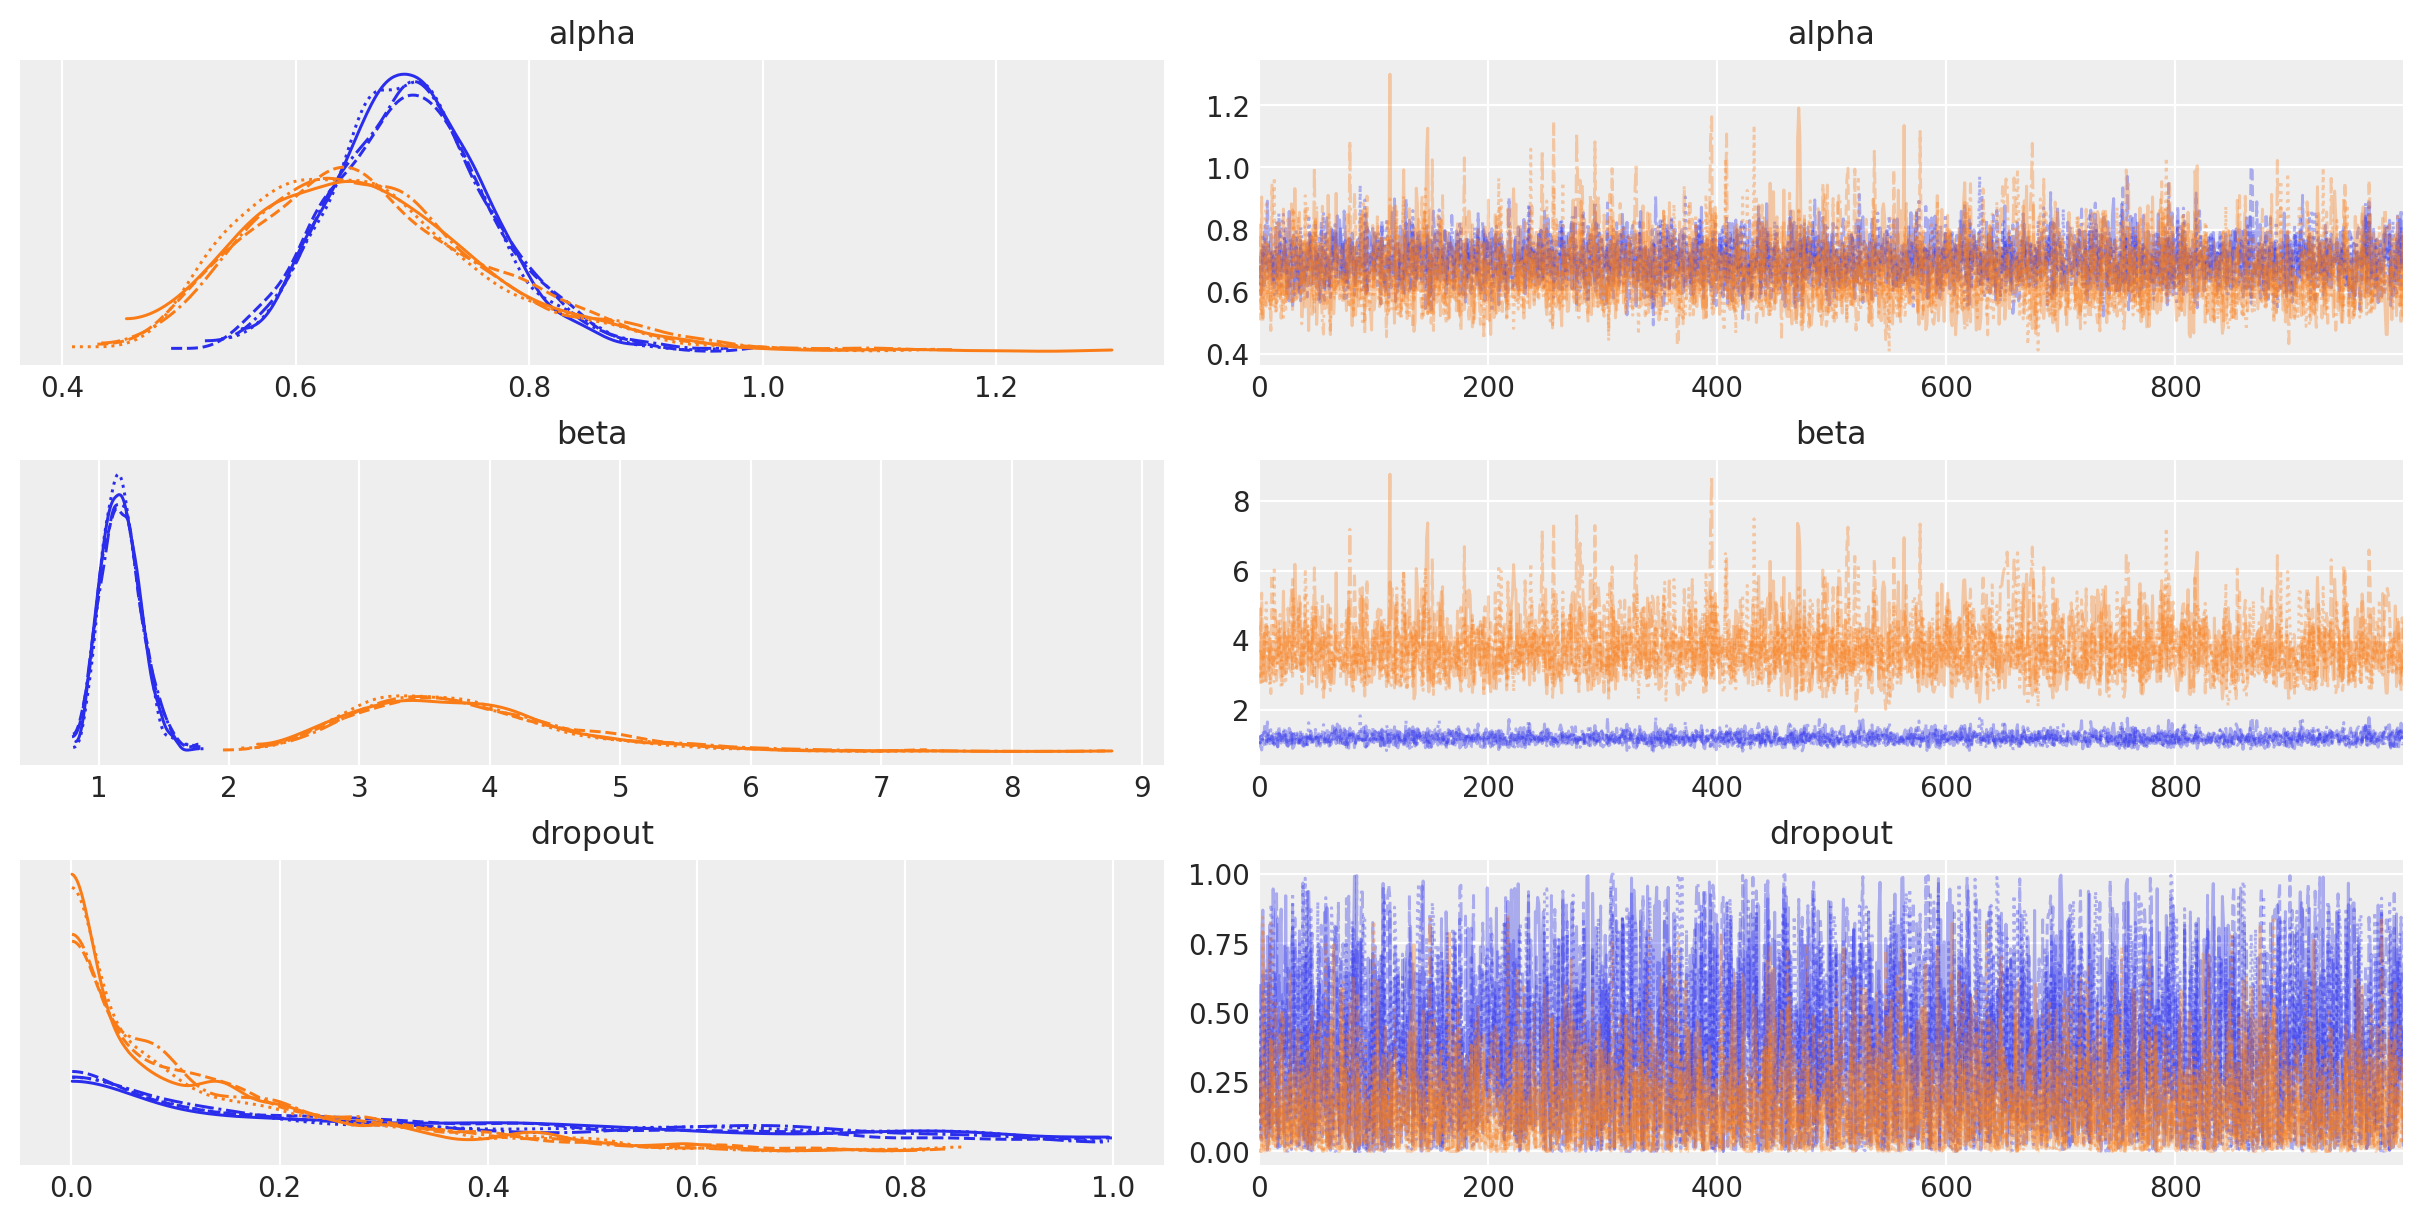

In [12]:
az.plot_trace(idata,var_names=["alpha", "beta", "dropout"])

In [13]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

## Contrasting posterior inferences with the repo MLE estimates

The sBG model has 2 population parameters of interest: `alpha` and `beta`. 
These parameters define the population distribution of the individual customer's churn rates `theta`. 
The larger the values of `alpha` and `beta` the more homogenous the churn rates are across different customers. 

The ratio of `alpha` to `beta` tells us the expected churn rates. If `alpha/beta == 0.1`, we expect the average customer to have a `0.1` probability of churning between each time period.

In [14]:
# MLE estimates from the paper
ref_val = {
    "highend": [0.688, 3.806],
    "regular": [0.704, 1.182],
}

In [15]:
az.summary(idata,var_names=["alpha", "beta", "dropout"]).index

Index(['alpha[regular]', 'alpha[highend]', 'beta[regular]', 'beta[highend]',
       'dropout[0]', 'dropout[1]'],
      dtype='object')

array([<Axes: title={'center': 'alpha\nregular'}>,
       <Axes: title={'center': 'alpha\nhighend'}>,
       <Axes: title={'center': 'beta\nregular'}>,
       <Axes: title={'center': 'beta\nhighend'}>], dtype=object)

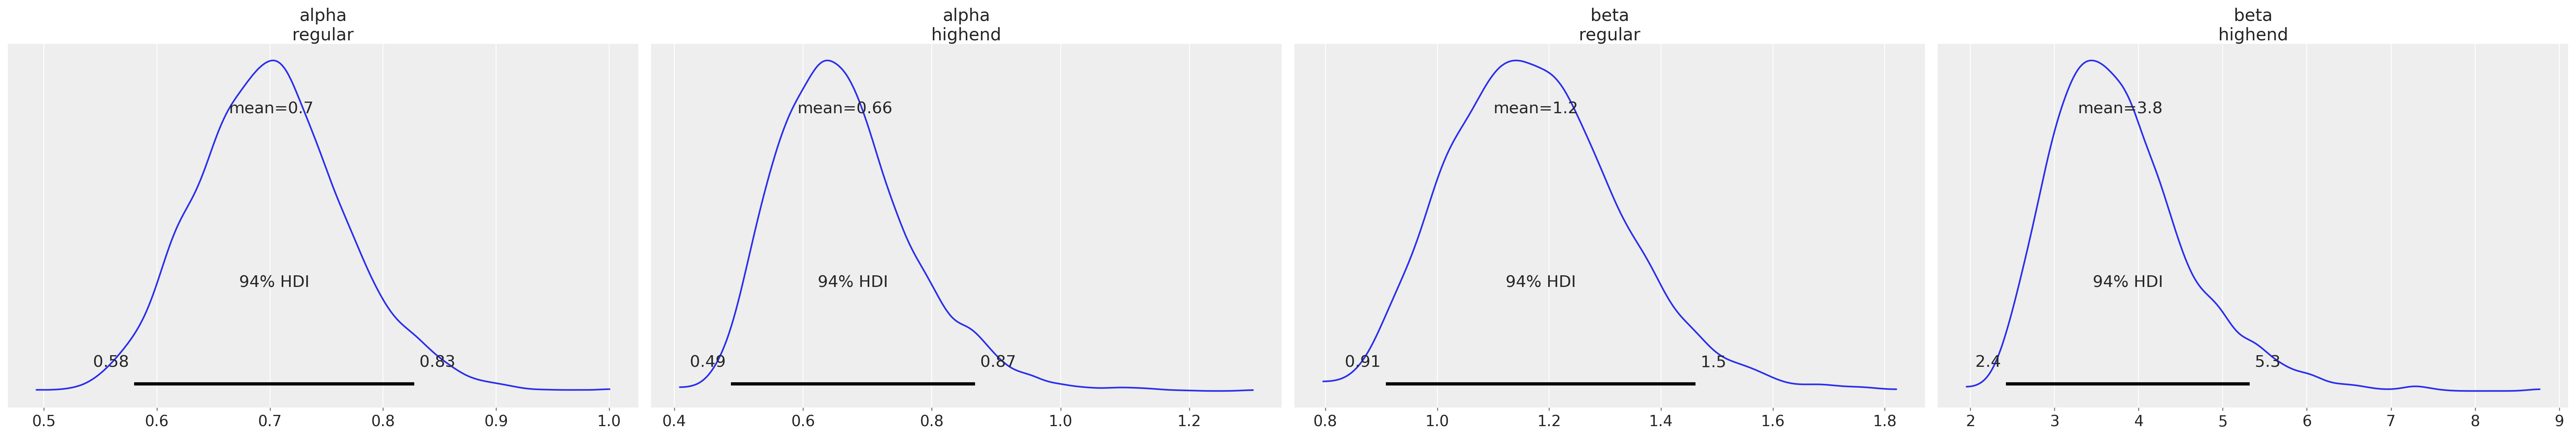

In [16]:
# Map cohort-wise [alpha, beta] refs to ArviZ variable labels
ref_val_map = {}
for cohort, (a_ref, b_ref) in ref_val.items():
    ref_val_map[f"alpha\n{cohort}"] = a_ref
    ref_val_map[f"beta\n{cohort}"]  = b_ref
   
az.plot_posterior(
    idata,  # InferenceData; uses the posterior group by default
    var_names=["alpha", "beta"],
    ref_val=ref_val_map,
)

The model fitting agrees with the Maximum Likelihood estimates described in the original paper.
In addition, MCMC sampling, gives us useful information about the uncertainty of the fits.

In [17]:
def retention_rate(alpha,beta,t):
    r_t = (beta+t-1)/(alpha+beta+t-1)
    return r_t

In [20]:
alpha = .704
beta = 1.182
retention_rate(alpha,beta, dataset_regular["t_churn"].unique())

array([0.62672322, 0.75606376, 0.81883685, 0.85591486, 0.88039416,
       0.89776358, 0.91072787, 0.92077425])

##### Create Dataset of Cohorts from Companion Papers

In [49]:
import numpy as np
import pandas as pd

# Cohort table from the markdown (empty cells omitted)
cohort_counts = {
    2001: {2001: 10000, 2002: 8000, 2003: 6480, 2004: 5307, 2005: 4391},
    2002: {2002: 10000, 2003: 8000, 2004: 6480, 2005: 5307},
    2003: {2003: 10000, 2004: 8000, 2005: 6480},
    2004: {2004: 10000, 2005: 8000},
    2005: {2005: 10000},
}
# (Bottom totals row is intentionally ignored)

rows = []
for cohort, year_counts in cohort_counts.items():
    years_sorted = sorted(year_counts)
    ages = [y - cohort for y in years_sorted]
    S = [year_counts[y] for y in years_sorted]  # survivors per age
    last_t = ages[-1]  # observation window for this cohort (right-censoring time T)

    # Churn in interval t -> t+1 (event observed at t)
    for t in range(len(S) - 1):
        count = S[t] - S[t + 1]
        if count > 0:
            rows.append({"cohort": cohort, "t_churn": t, "T": last_t, "count": count})

    # Right-censored at last observed age (still active)
    if S[-1] > 0:
        rows.append({"cohort": cohort, "t_churn": last_t, "T": last_t, "count": S[-1]})

counts_df = pd.DataFrame(rows)

# Expand to one row per customer
t_churn_array = np.repeat(counts_df["t_churn"].to_numpy(), counts_df["count"].to_numpy())
T_array = np.repeat(counts_df["T"].to_numpy(), counts_df["count"].to_numpy())
cohort_array = np.repeat(counts_df["cohort"].to_numpy(), counts_df["count"].to_numpy())
customer_id = np.arange(t_churn_array.size)

df = pd.DataFrame(
    {
        "customer_id": customer_id,
        "t_churn": t_churn_array + 1,
        "T": T_array + 1,
        "cohort": cohort_array,
    }
).astype({"customer_id": int, "t_churn": int, "T": int, "cohort": str})

df

,customer_id,t_churn,T,cohort
0,0,1,5,2001
1,1,1,5,2001
2,2,1,5,2001
3,3,1,5,2001
4,4,1,5,2001
...,...,...,...,...
49995,49995,1,1,2005
49996,49996,1,1,2005
49997,49997,1,1,2005
49998,49998,1,1,2005


In [71]:
cohort_idx = pd.Categorical(df["cohort"], categories=df.cohort.unique()).codes

coords = {
    "customer_id": df["customer_id"],
    "cohort": df.cohort.unique(),
}
with pm.Model(coords=coords) as model:
    
    alpha = pm.HalfFlat("alpha",dims="cohort")
    beta = pm.HalfFlat("beta",dims="cohort")

    # phi = pm.Uniform("phi", lower=0, upper=1)
    # kappa = pm.Pareto("kappa", alpha=1,m=1,dims="cohort")

    # alpha = pm.Deterministic("alpha", phi * kappa)#,dims=("cohort")
    # beta = pm.Deterministic("beta", (1 - phi) * kappa)#,dims=("cohort",))
    #theta = pm.Beta("dropout",alpha=alpha,beta=beta)

    sbg = clv.distributions.ShiftedBetaGeometric.dist(
        alpha[cohort_idx],
        beta[cohort_idx],
    )

    pm.Censored(
        "churn_censored",
        sbg,
        lower=None,
        upper=df["T"],
        observed=df["t_churn"],
        dims="customer_id",
    )

    #idata = pm.sample()#nuts_sampler="nutpie")
    idata = pm.find_MAP()

Output()

In [72]:
idata

{'alpha_log__': array([ 1.34115052e+00,  1.34234229e+00,  1.33512149e+00, -6.93143143e-01,
         2.69856324e-13]),
 'beta_log__': array([2.72792517e+00, 2.72881578e+00, 2.72146237e+00, 6.93143143e-01,
        1.60558837e-13]),
 'alpha': array([3.8234399 , 3.82799931, 3.80045765, 0.50000202, 1.        ]),
 'beta': array([15.30110681, 15.31474024, 15.20253766,  1.99999193,  1.        ])}

## Recreating main results and figures from the paper

Figure 6 from the paper shows the group distribution of `theta` churn rates. 

The inferred distributions are relatively wide in both groups, which follows directly from the fact that both `alpha` and `beta` were inferred to be < 10.

It is still clear that the distribution of `theta` for the highend users has much more mass near lower values,
suggesting highend users have lower attrition rates on average, when compared with regular users.

### Hierarchal Partial Pooling

# Original Paper Results

In [18]:
new_highend_theta = highend_users.distribution_new_customer_theta(
    n=100, random_seed=rng
)
new_regular_theta = regular_users.distribution_new_customer_theta(
    n=100, random_seed=rng
);

Sampling: [theta]


Output()

Sampling: [theta]


Output()

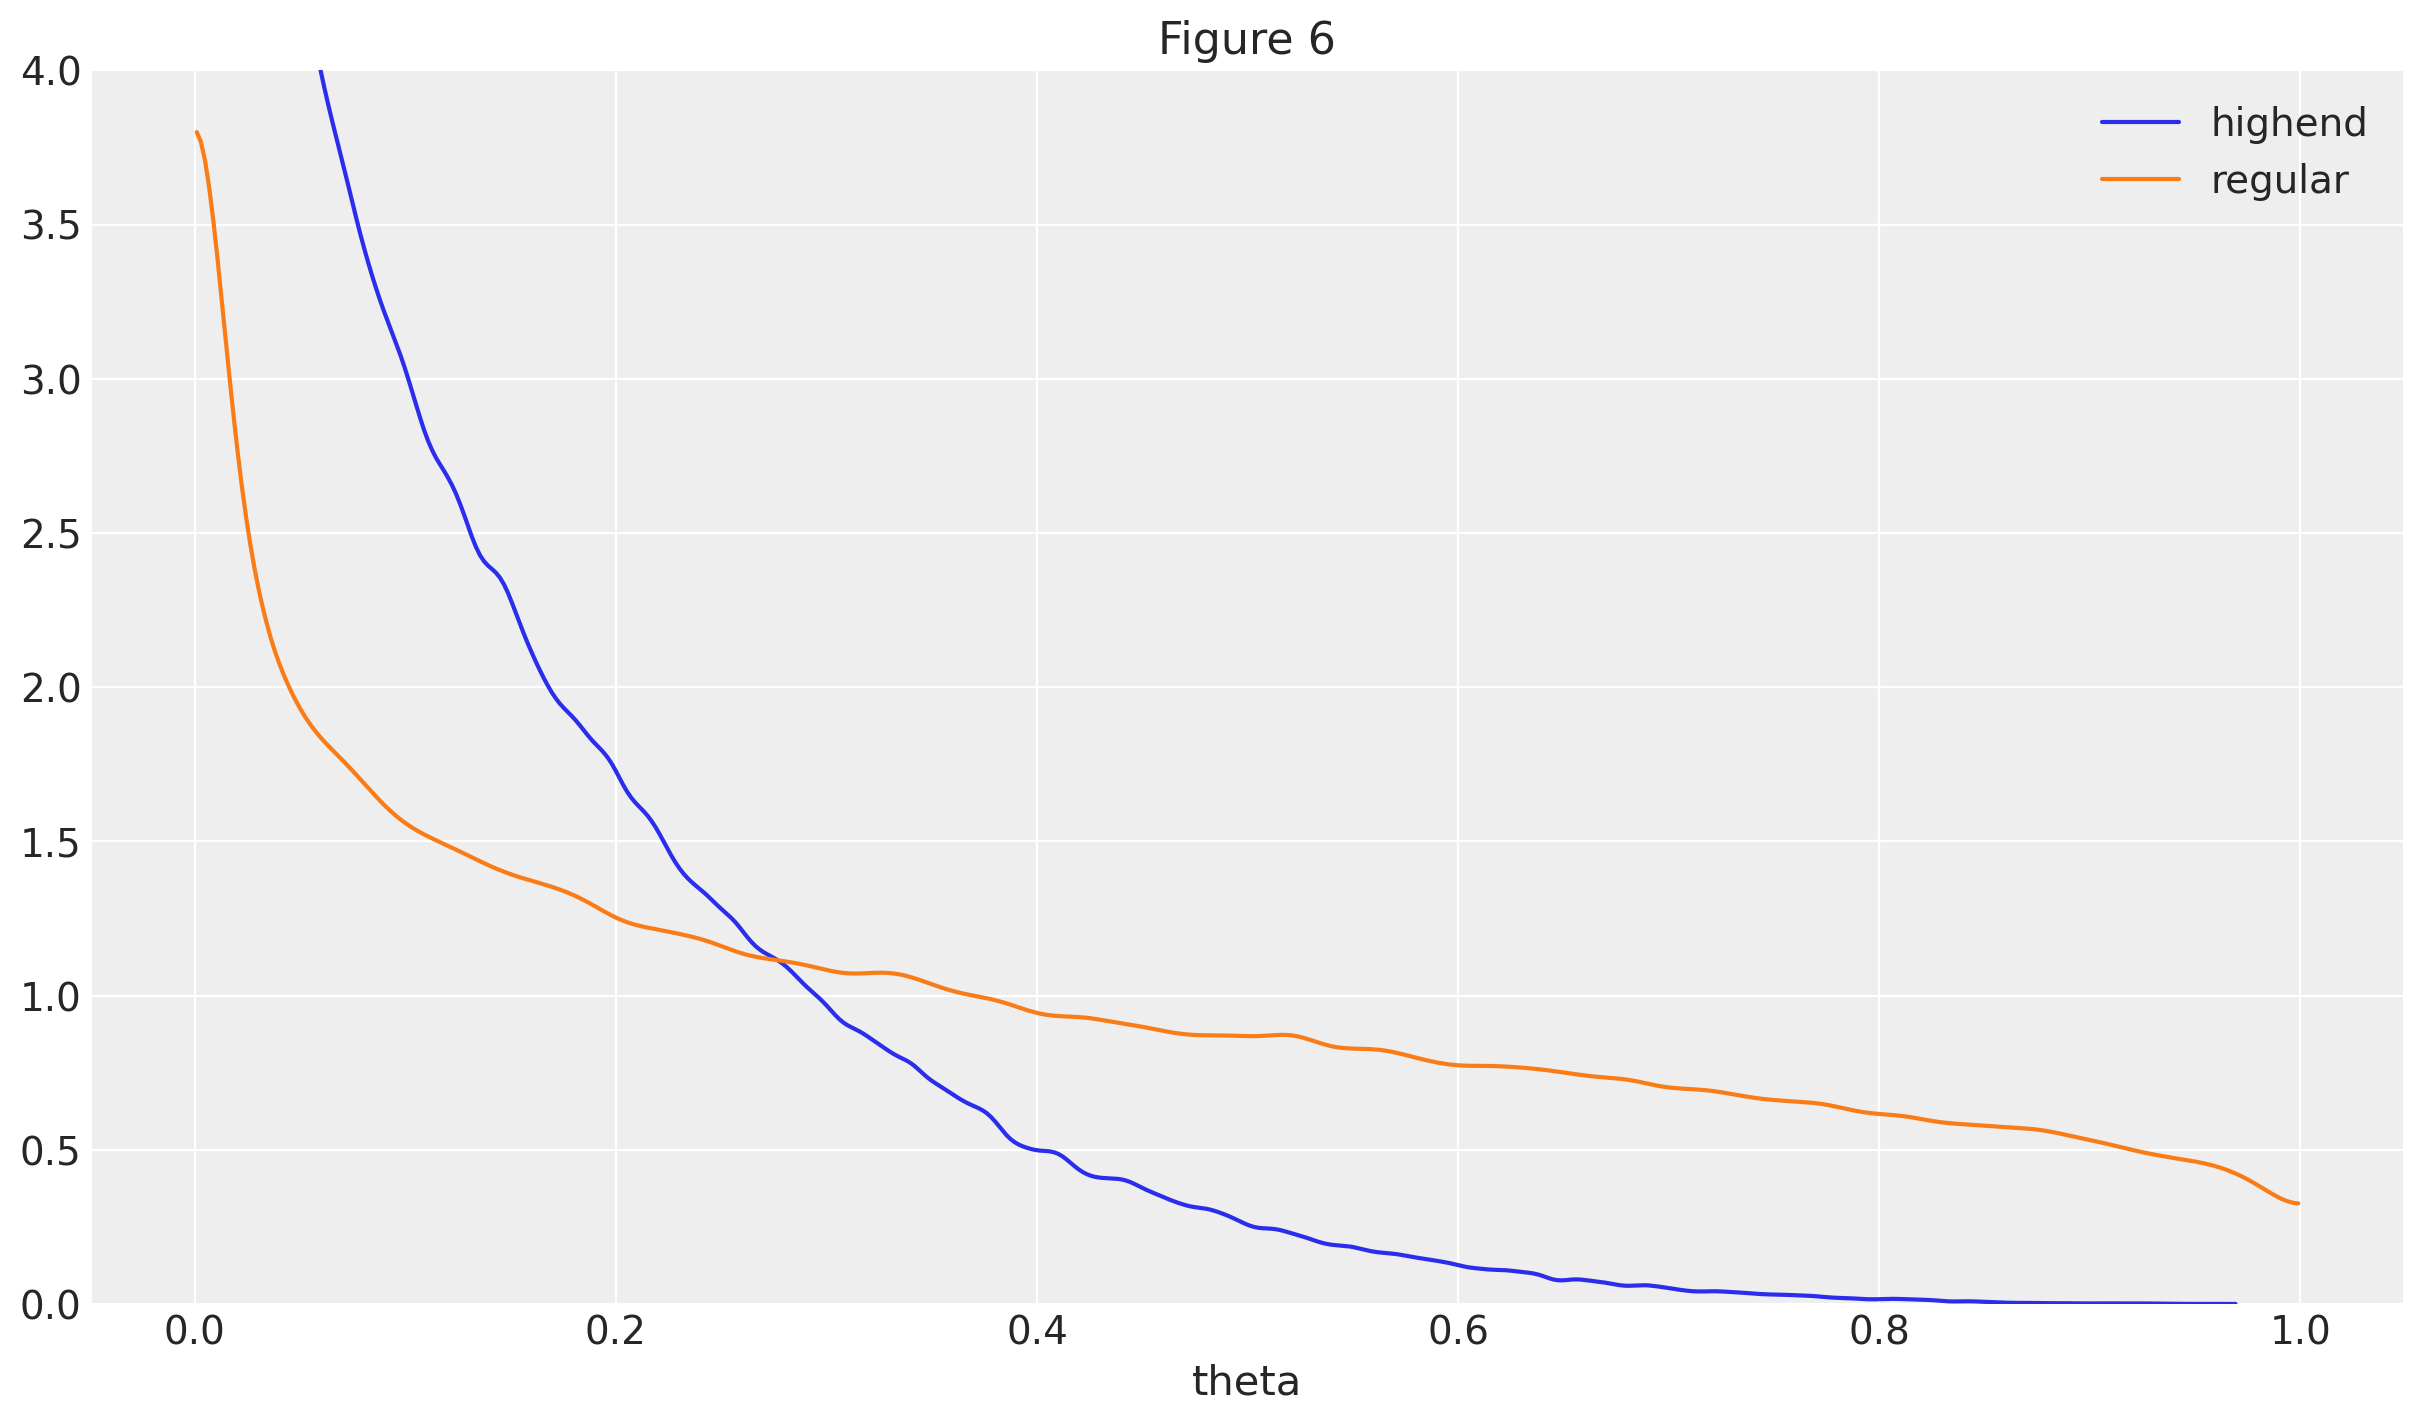

In [19]:
ax = az.plot_dist(new_highend_theta, label="highend")
ax = az.plot_dist(new_regular_theta, label="regular", ax=ax, color="C1")
ax.set_xlabel("theta")
plt.ylim([0, 4])
ax.set_title("Figure 6");

Figures 4 and 5 show the predicted average churn and retention trends for the two groups.
We can see that predictions nicely match the observed data (black line), even when extrapolating into the time periods that were held-out when fitting the model.

The plots also highlight an interesting implication from the model: 
the retention rates are expected to increase over time, as the more precarious customers gradually drop out. This is a direct consequence of modelling individual churn rates as being fixed over time.

In [20]:
churn_highend = highend_users.distribution_customer_churn_time(
    customer_id=np.arange(initial_customers),
    random_seed=rng,
)
churn_regular = regular_users.distribution_customer_churn_time(
    customer_id=np.arange(initial_customers),
    random_seed=rng,
)

Sampling: [churn]


Output()

Sampling: [churn]


Output()

In [21]:
weeks = xr.DataArray(np.arange(1, 14), dims=["weeks"])

survival_perc_highend = 100 - 100 * (churn_highend < weeks)
survival_perc_regular = 100 - 100 * (churn_regular < weeks)

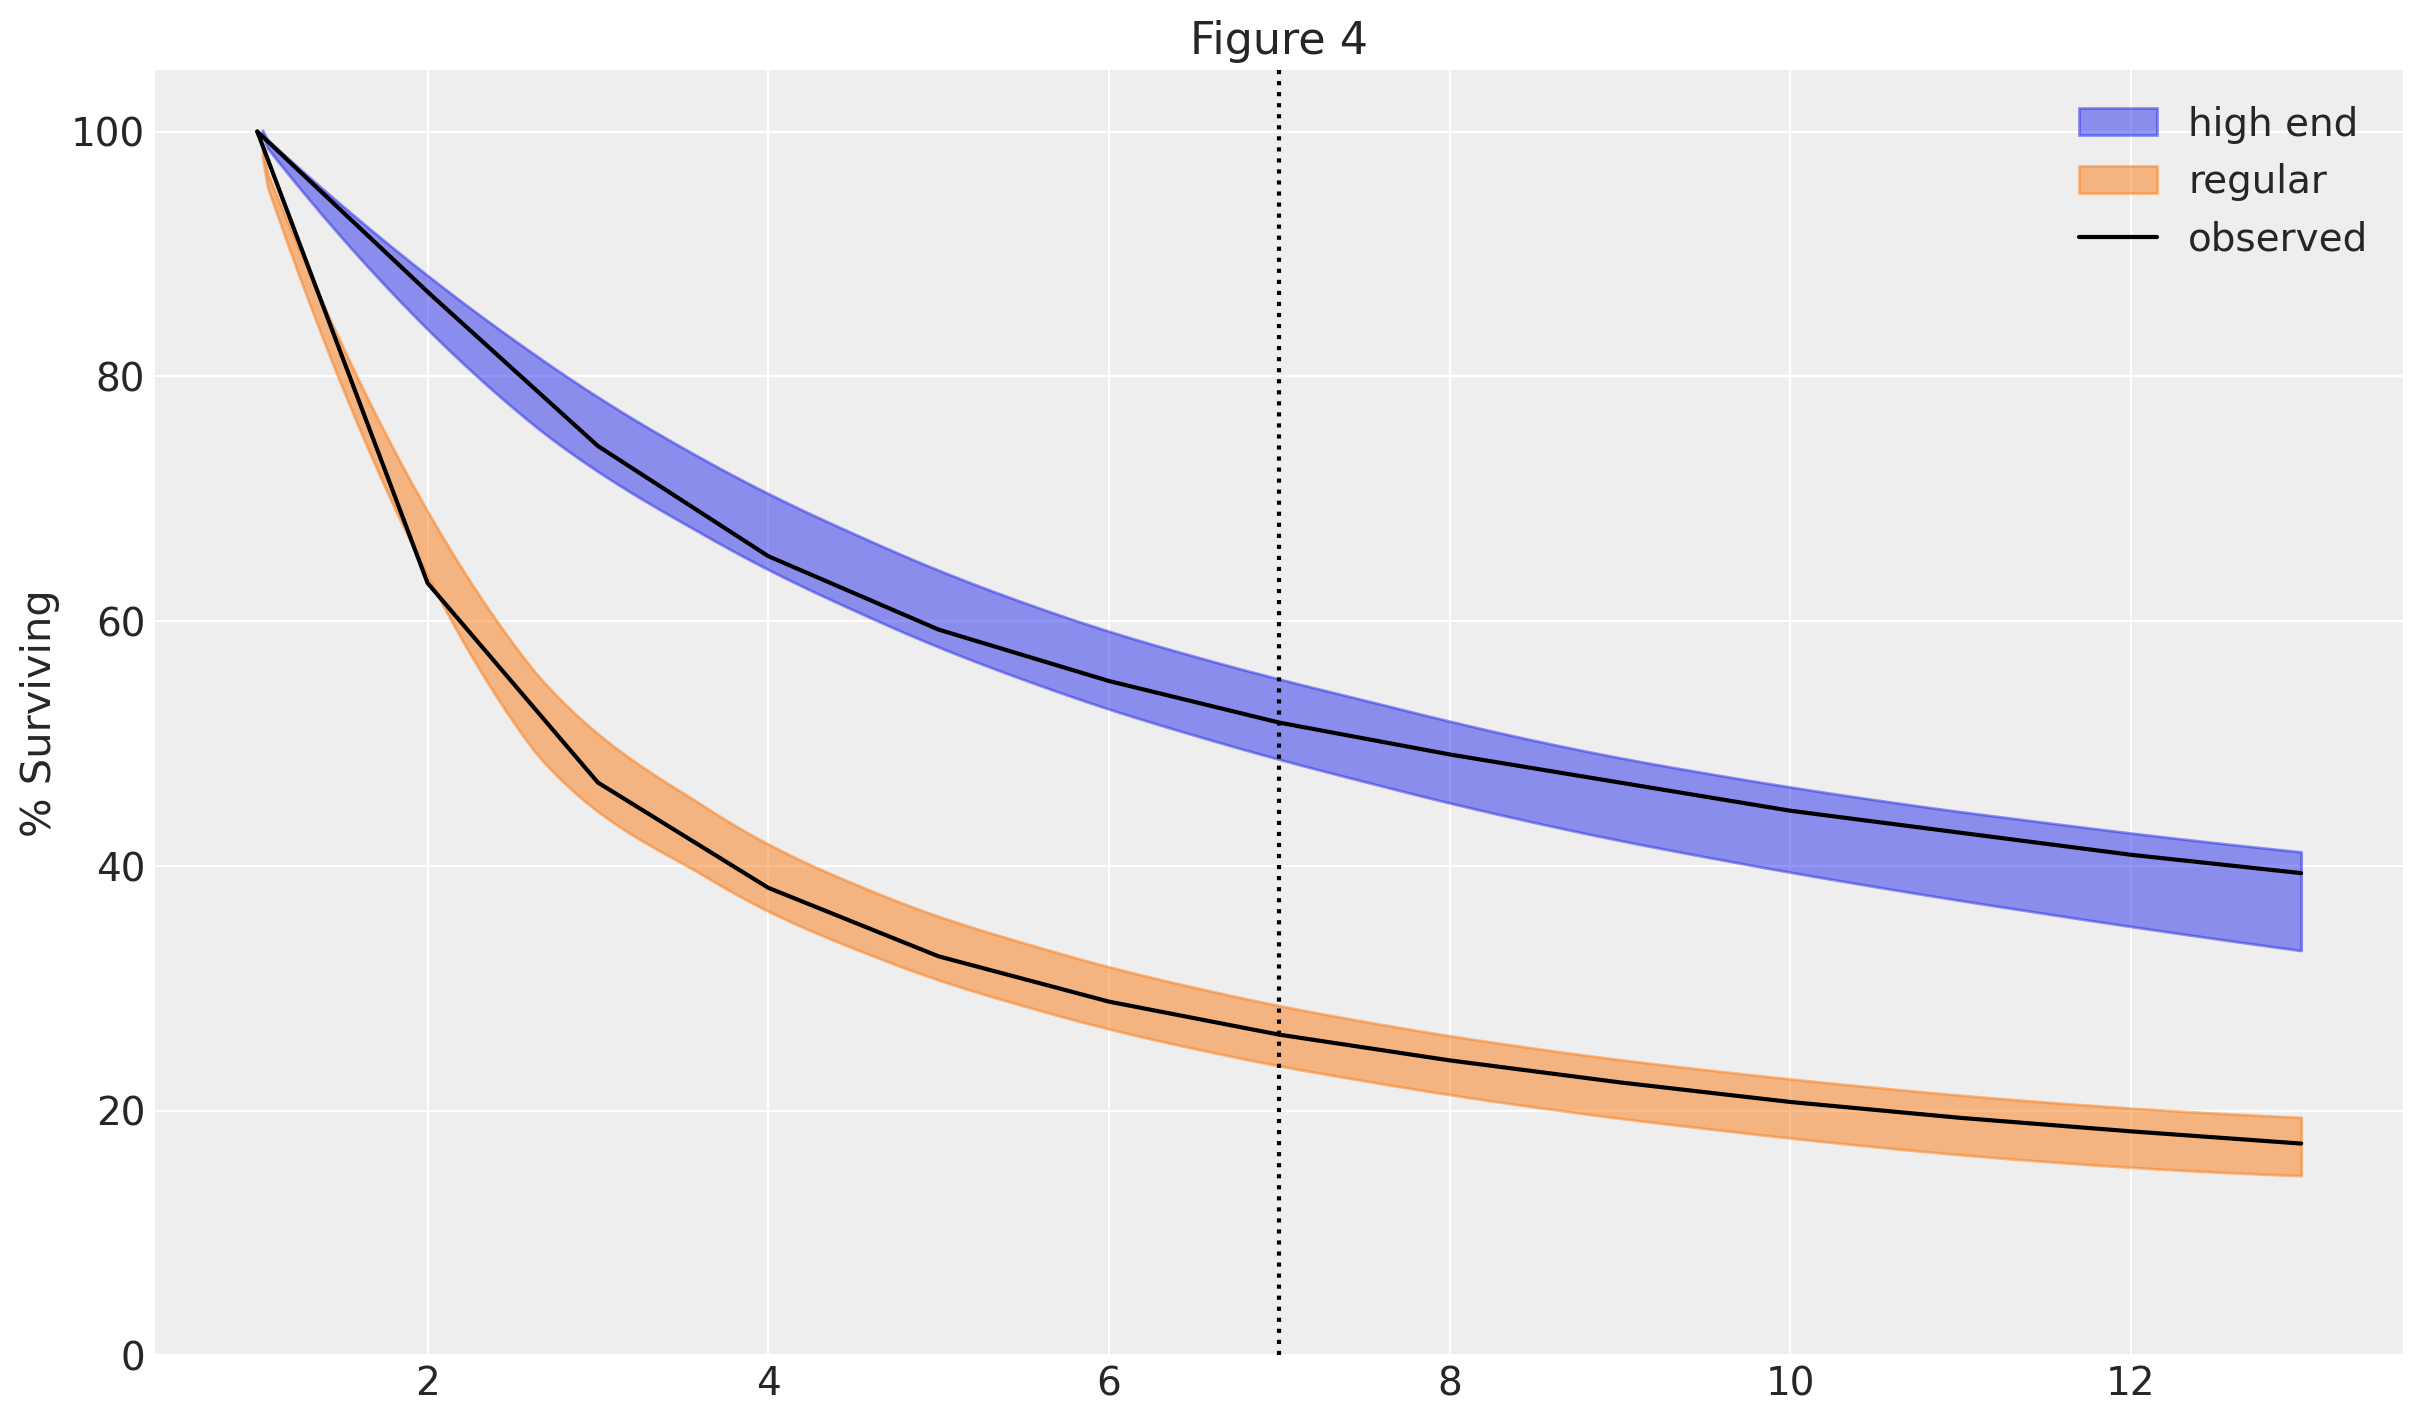

In [22]:
az.plot_hdi(
    weeks,
    survival_perc_highend.mean("customer_id"),
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"label": "high end"},
)
az.plot_hdi(
    weeks,
    survival_perc_regular.mean("customer_id"),
    hdi_prob=0.95,
    color="C1",
    fill_kwargs={"label": "regular"},
)

plt.plot(weeks, df["highend"], color="k", label="observed")
plt.plot(weeks, df["regular"], color="k")

plt.axvline(7, ls=":", color="k")
plt.ylim([0, 105])
plt.ylabel("% Surviving")
plt.legend()
plt.title("Figure 4");

In [23]:
retention_rate_highend = survival_perc_highend.isel(
    weeks=slice(1, None, None)
) / survival_perc_highend.isel(weeks=slice(None, -1, None))
retention_rate_regular = survival_perc_regular.isel(
    weeks=slice(1, None, None)
) / survival_perc_regular.isel(weeks=slice(None, -1, None))

retention_rate_highend_obs = df["highend"][1:].values / df["highend"][:-1].values
retention_rate_regular_obs = df["regular"][1:].values / df["regular"][:-1].values

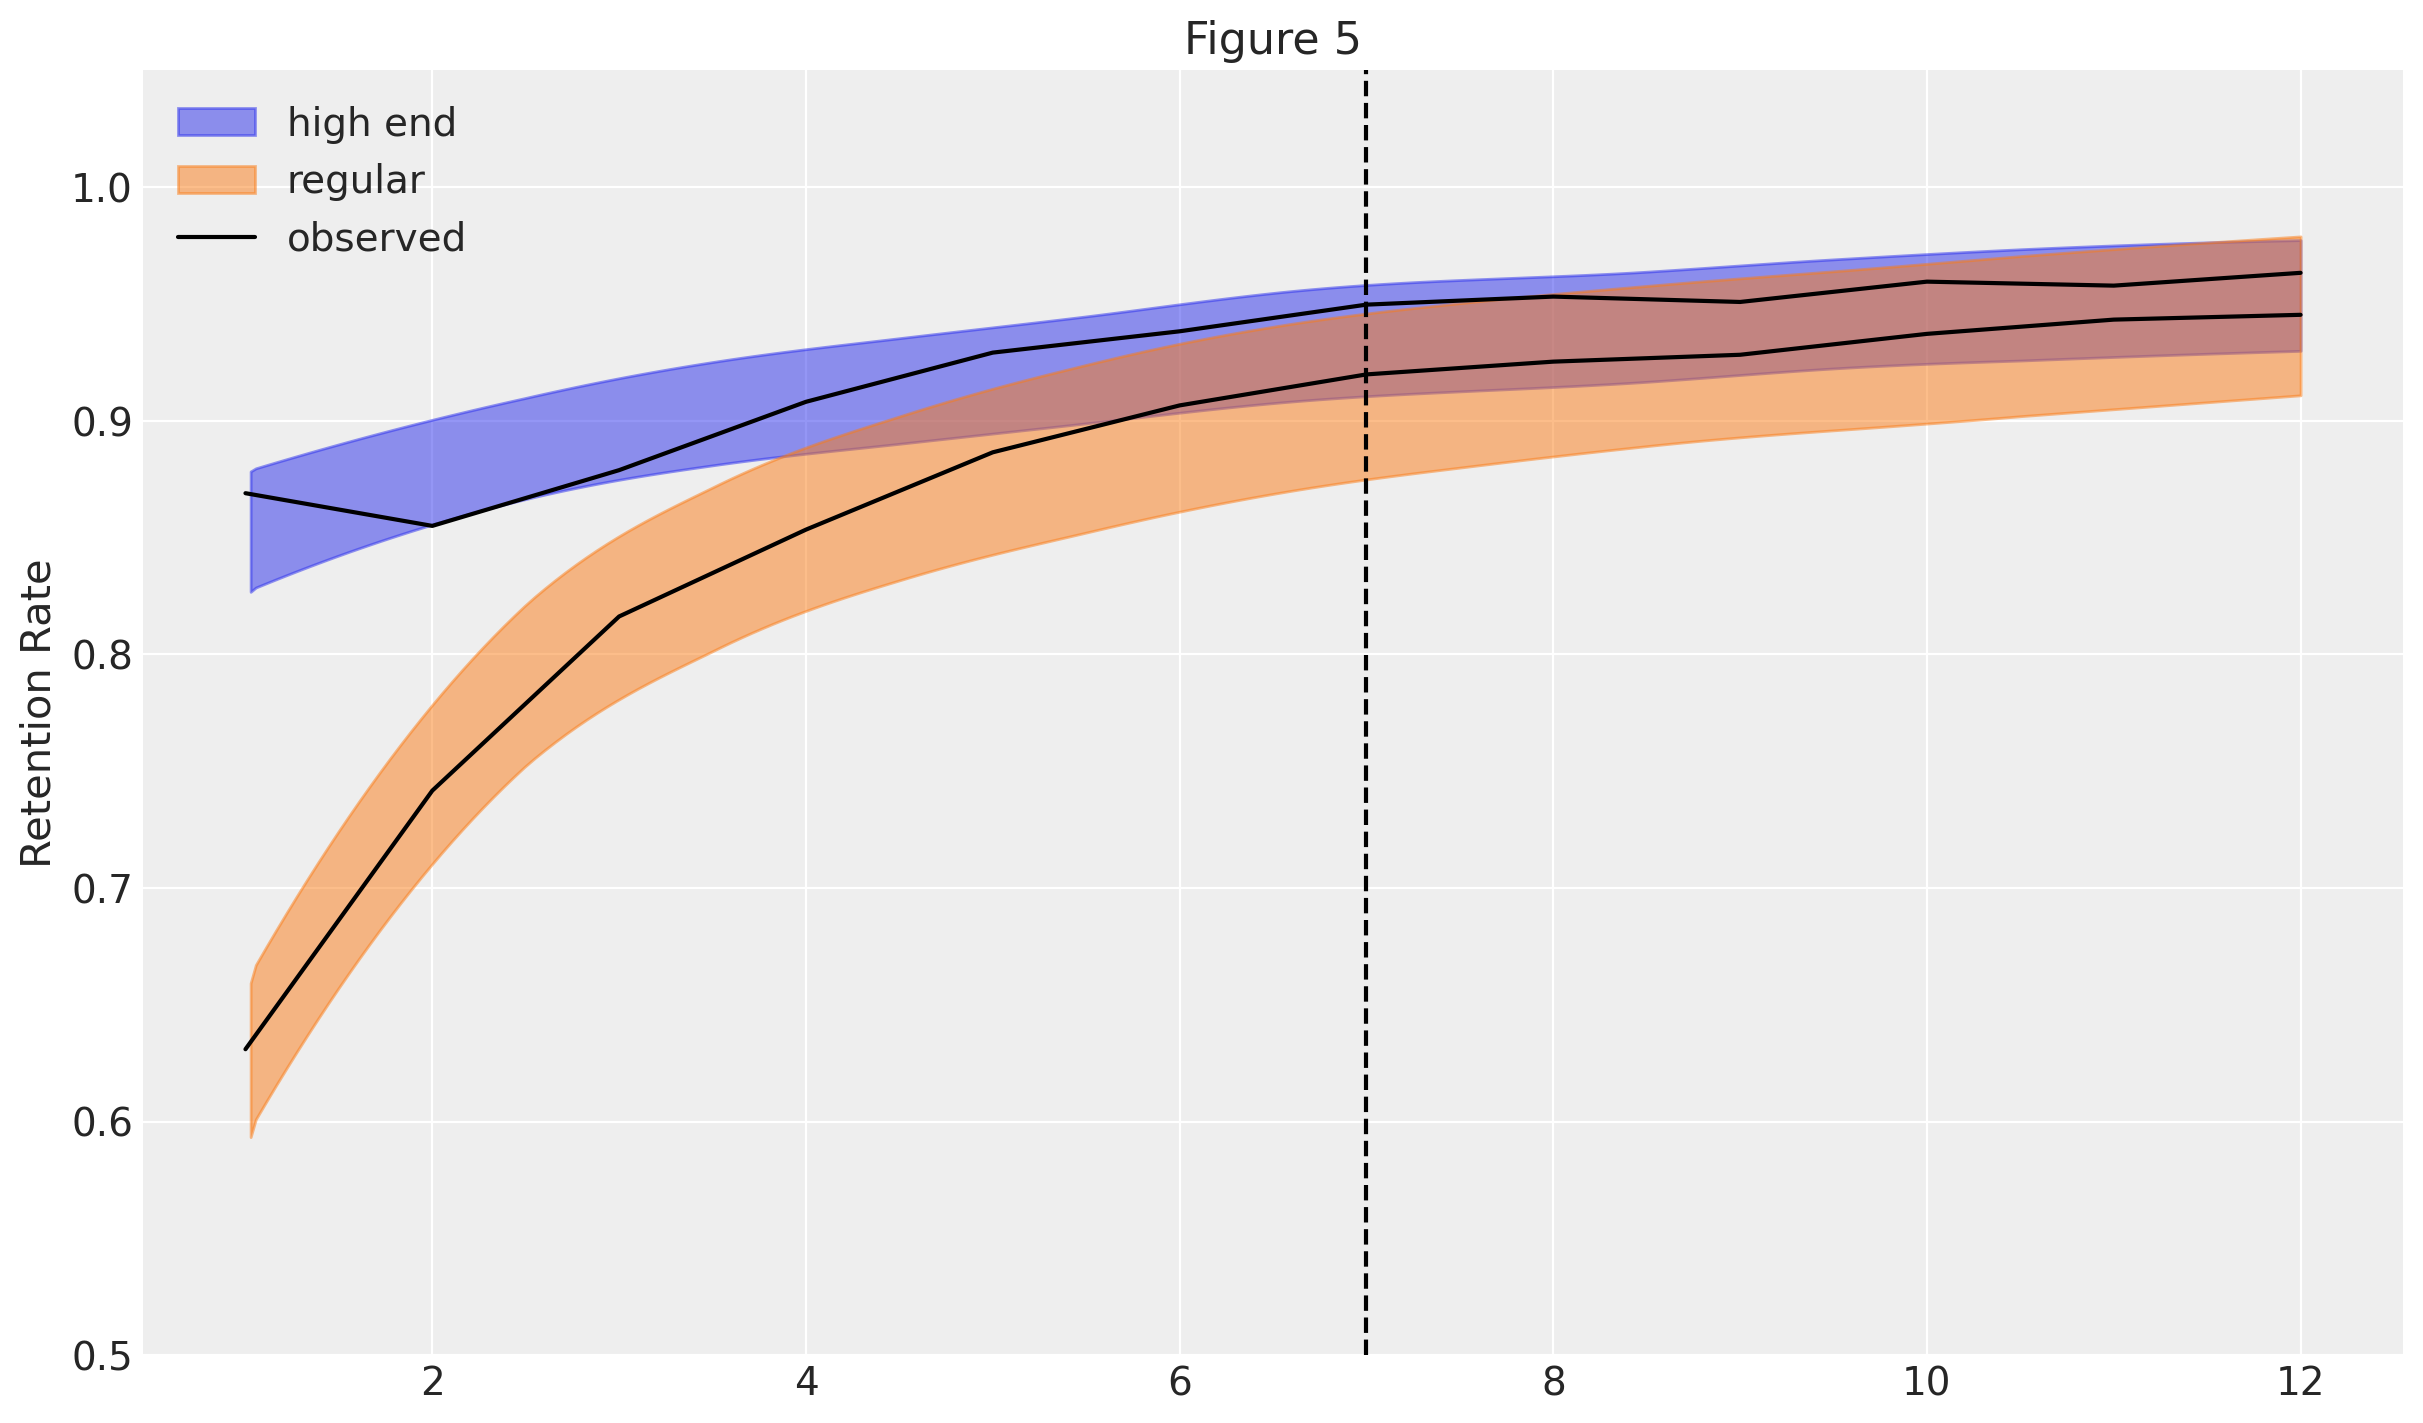

In [24]:
weeks_ = weeks[:-1]

az.plot_hdi(
    weeks_,
    retention_rate_highend.mean("customer_id"),
    hdi_prob=0.95,
    color="C0",
    fill_kwargs={"label": "high end"},
)
az.plot_hdi(
    weeks_,
    retention_rate_regular.mean("customer_id"),
    hdi_prob=0.95,
    color="C1",
    fill_kwargs={"label": "regular"},
)

plt.plot(weeks_, retention_rate_highend_obs, color="k", label="observed")
plt.plot(weeks_, retention_rate_regular_obs, color="k")

plt.axvline(7, ls="--", color="k")
plt.ylim([0.5, 1.05])
plt.ylabel("Retention Rate")
plt.legend()
plt.title("Figure 5");

In [25]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Mon Nov 11 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.26.0

pymc    : 5.13.0
pytensor: 2.20.0

arviz         : 0.19.0
matplotlib    : 3.8.4
pandas        : 2.2.2
xarray        : 2024.6.0
pymc_marketing: 0.10.0
numpy         : 1.26.4

Watermark: 2.4.3

